In [25]:
import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub
from util.consts import MTU,UNIT_G,LINK_TO_DELAY_DICT,SIZE_BUCKET_LIST_OUTPUT,get_base_delay_transmission,get_base_delay,get_size_bucket_list_output,SIZE_BUCKET_LIST_LABEL_OUTPUT
import matplotlib.pyplot as plt
import json
import glob
import os

In [26]:
dir_input="/data2/lichenni/path_perflow_busy"
dir_input_str=''
topo_type_ori="_topo-pl-x_"
lr=10
BDP=10*MTU
SIZE_BUCKET_LIST=[MTU, BDP, 5 * BDP]
enable_longest_foreground_traffic=True
lr_bottleneck=lr

dir_train: /data2/lichenni/output_perflow/fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps loads 84107 tracks
dir_train: /data2/lichenni/output_perflow/fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps loads 84171 tracks
(2, 10000, 5, 2)


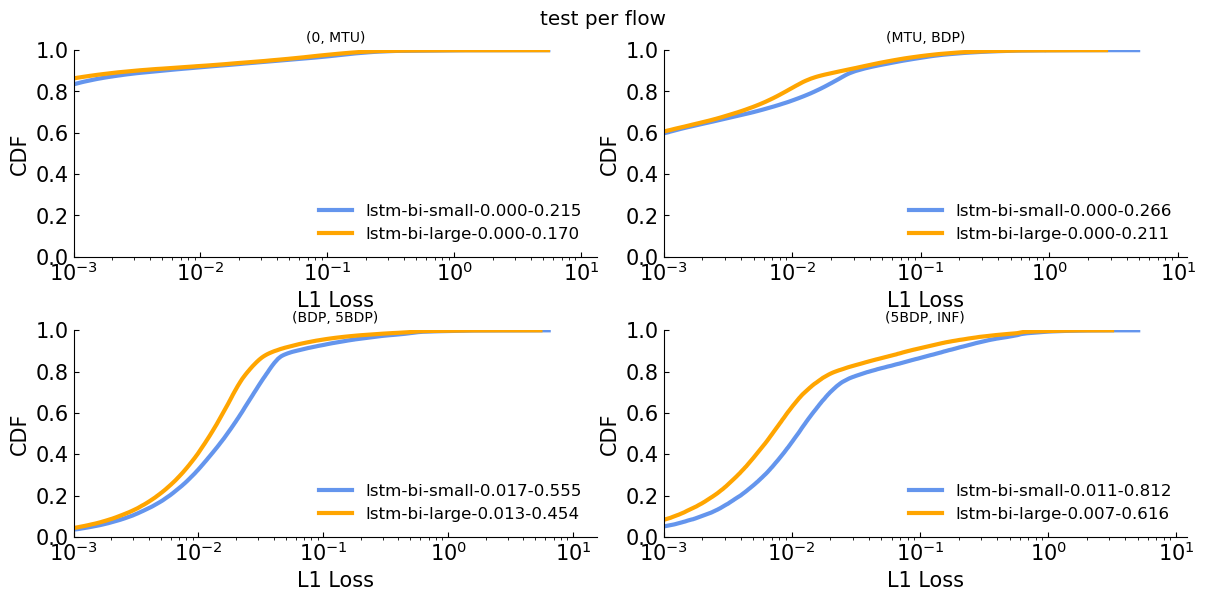

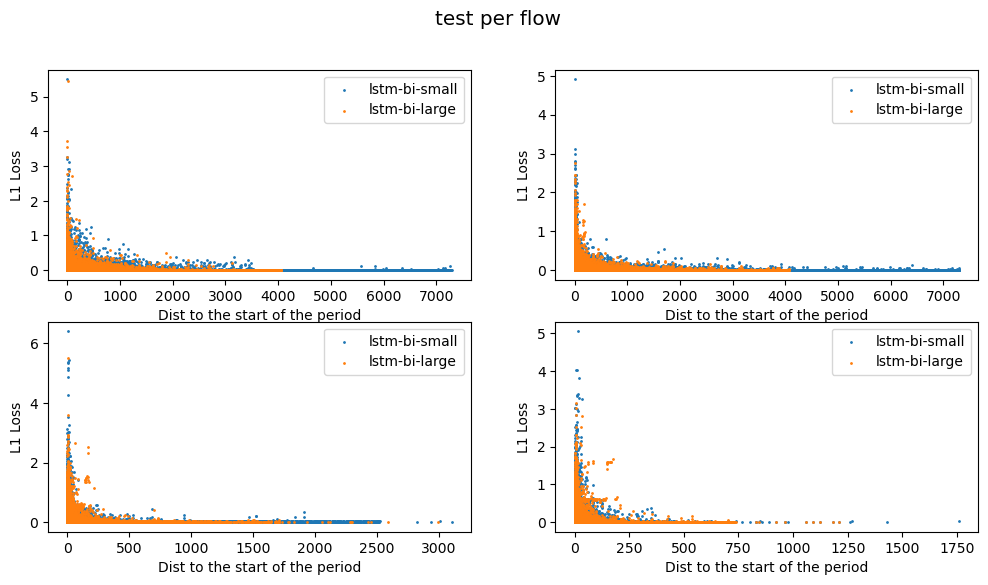

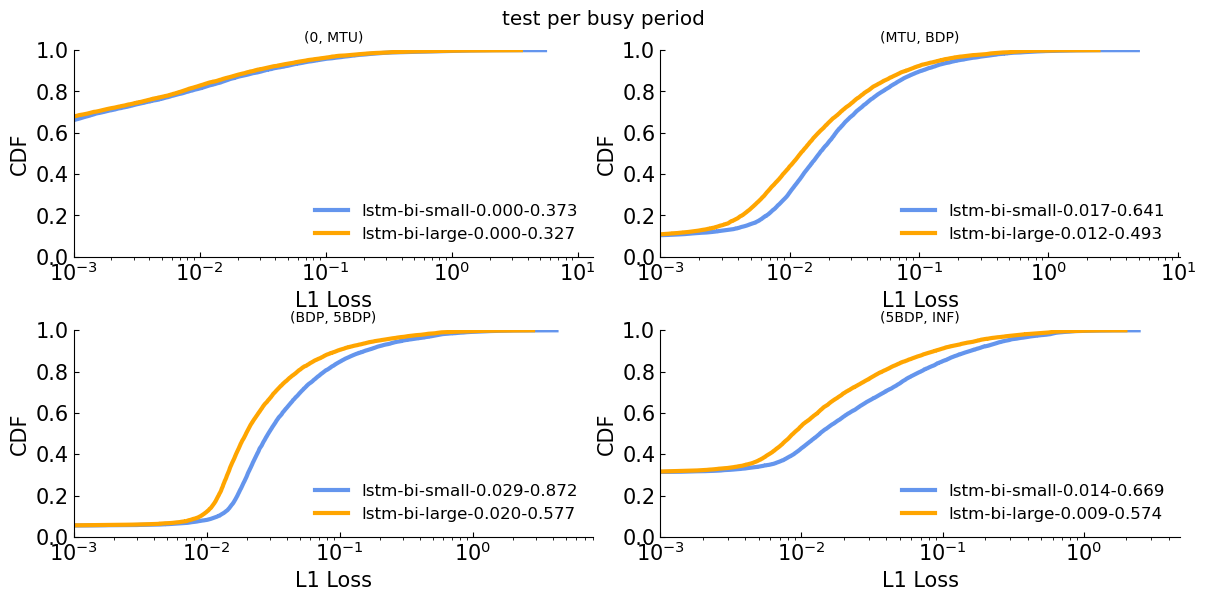

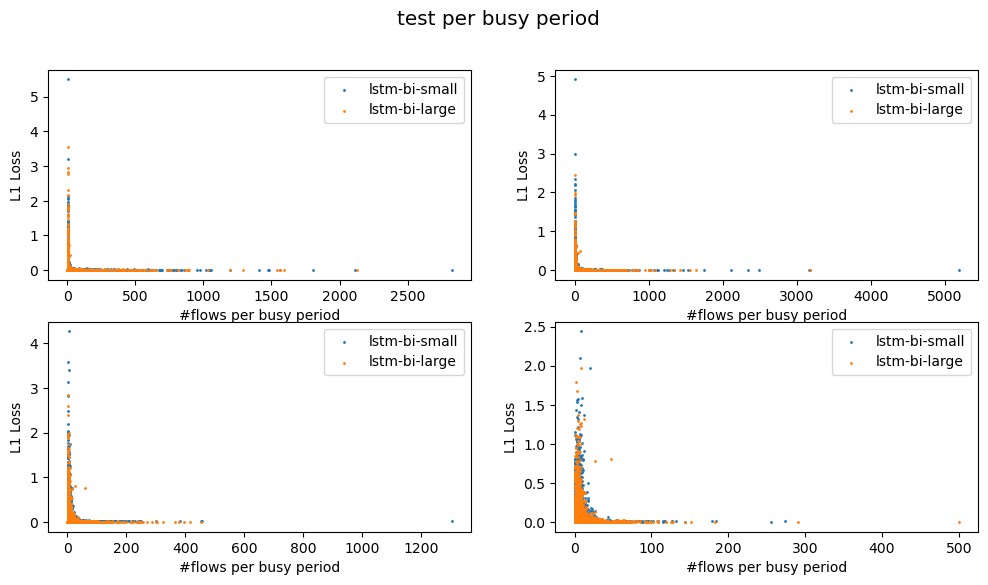

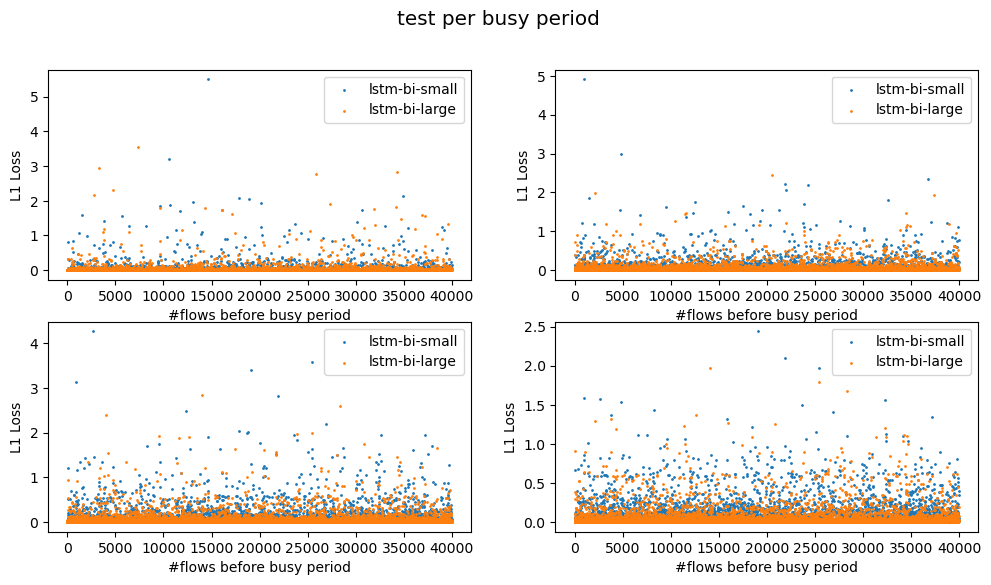

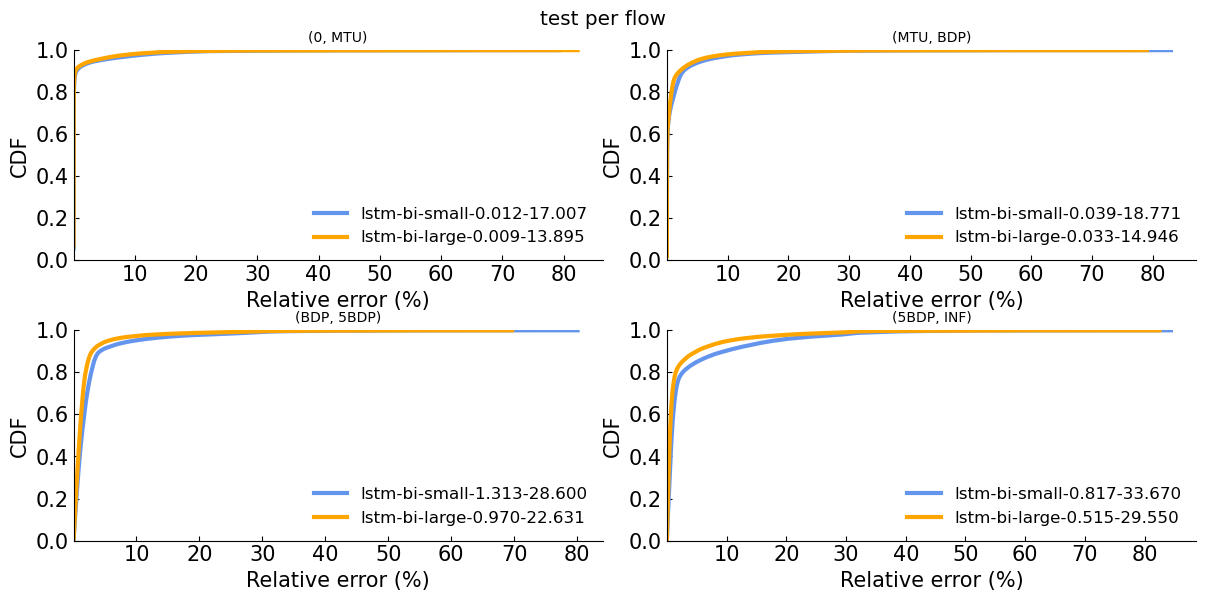

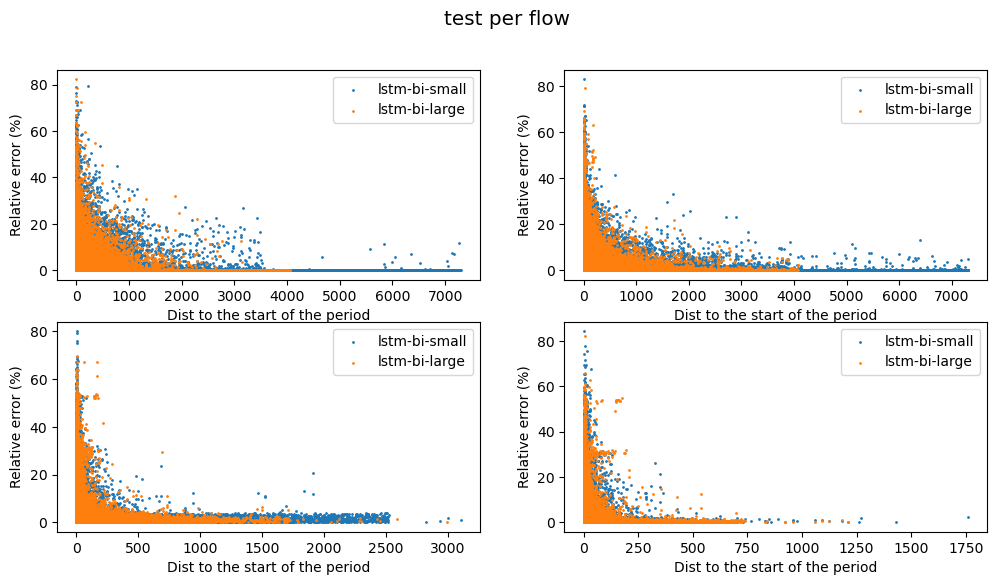

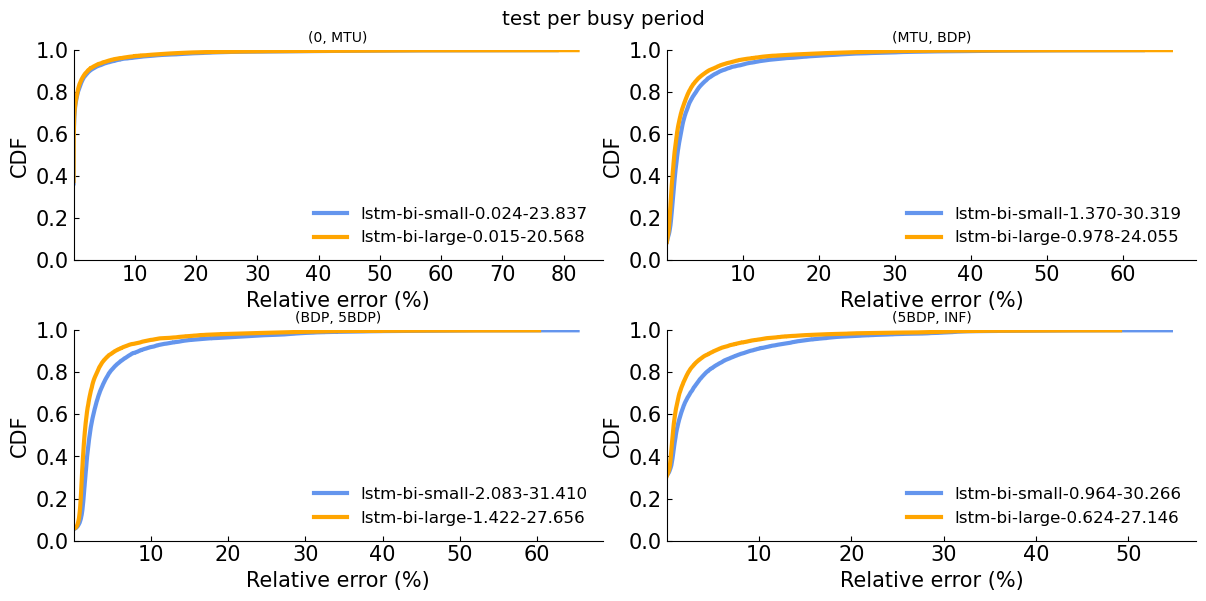

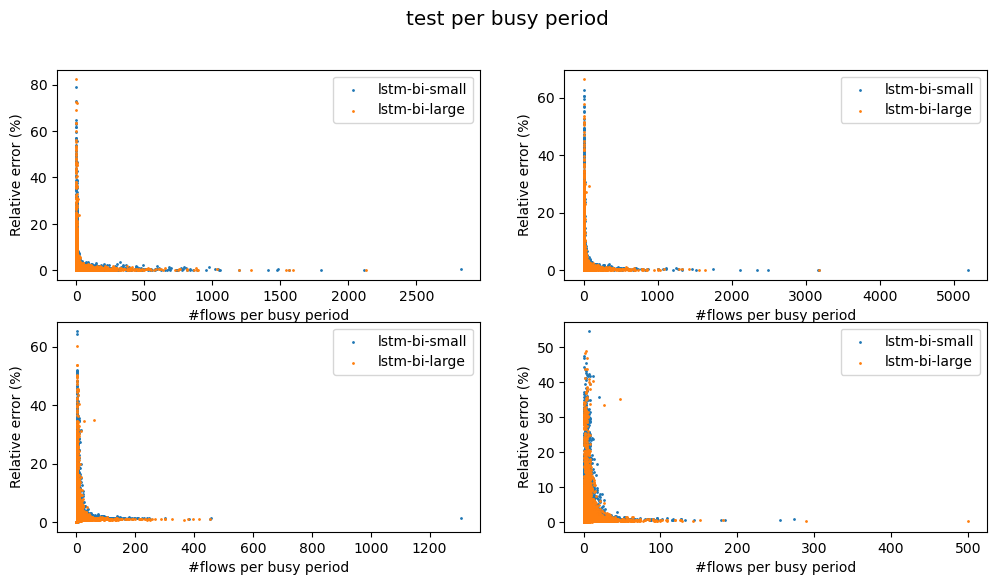

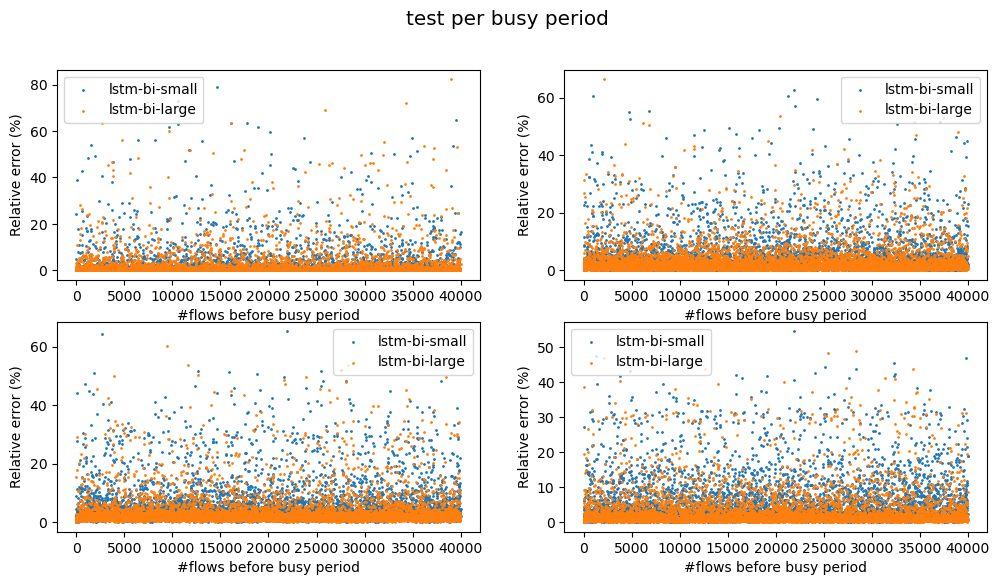

In [44]:
dir_input_synthetic="/data2/lichenni/path_perflow_busy"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0]
]

segments_per_seq=100
title_str_list = ["lstm-bi-small","lstm-bi-large"]
main_title_list=['train','test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

for version_id_test in [1]:
    fig_index=0
    res_total=[]
    num_total=[]
    res_total_per_seg=[]
    num_total_per_seg=[]
    
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0 or version_id_test==1:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                if version_id_test==0:
                    data_list_test=data_list["train"]
                else:
                    data_list_test=data_list["test"]
                    
                dir_input=dir_input_synthetic
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(0, 1000):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}", int(segment_id))
                                    )
            
            len_tracks=len(data_list_test)
            
            data_list_test_idx=np.random.choice(len(data_list_test),10000, replace=False)
            data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_model=[[[],[]] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT))]
            num_per_model=[[] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT))]
            res_per_model_per_seg=[]
            num_per_model_per_seg=[]
            
            for spec, src_dst_pair_target, topo_type, segment_id in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                # data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
                queue_len_est = data['queue_len_est']
                output = data['output']
                
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                fid=[int(flow_id) for flow_id in busy_periods[segment_id]]
                
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins=np.digitize(sizes,size_bucket_list)
                res_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,len(metric_label_list)))  
                num_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,2))
                
                for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
                    gt = np.extract(bins==i, output)
                    estimated = np.extract(bins==i, queue_len_est)
                    fid_tmp=np.extract(bins==i, fid)
                    if len(gt)==0:
                        continue
                    res_per_model[i][0].extend(np.abs(gt - estimated))
                    res_per_model[i][1].extend(np.abs(gt - estimated)/gt*100)
                    num_per_model[i].extend(fid_tmp-np.min(fid_tmp))
                    
                    res_per_bucket[i,0]=np.mean(np.abs(gt - estimated))
                    res_per_bucket[i,1]=np.mean(np.abs(gt - estimated)/gt)*100
                    num_per_bucket[i,0]=len(gt)
                    num_per_bucket[i,1]=np.min(fid_tmp)
                res_per_bucket[-1,0]=np.mean(np.abs(output - queue_len_est))
                res_per_bucket[-1,1]=np.mean(np.abs(output - queue_len_est)/output)*100
                num_per_bucket[-1,0]=len(output)
                num_per_bucket[-1,1]=np.min(fid)
                
                res_per_model_per_seg.append(res_per_bucket) 
                num_per_model_per_seg.append(num_per_bucket)
            res_total.append(res_per_model)
            num_total.append(num_per_model)
            res_total_per_seg.append(res_per_model_per_seg)
            num_total_per_seg.append(num_per_model_per_seg)
    res_total_per_seg=np.array(res_total_per_seg)
    print(res_total_per_seg.shape) 
    num_total_per_seg=np.array(num_total_per_seg)
    
    for metric_idx in range(len(metric_label_list)):
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(res_total[0][i][metric_idx]),np.array(res_total[1][i][metric_idx])]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(res_total[0][i][metric_idx]),np.array(res_total[1][i][metric_idx])]
            res_num=[np.array(num_total[0][i]),np.array(num_total[1][i])]
            plt.subplot(2, 2, i + 1)
            plt.scatter(res_num[0],res[0],label=title_str_list[0],s=1)
            plt.scatter(res_num[1],res[1],label=title_str_list[1],s=1)
            plt.legend()
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            res_num=[x[:,i,0] for x in num_total_per_seg]
            plt.subplot(2, 2, i + 1)
            plt.scatter(res_num[0],res[0],label=title_str_list[0],s=1)
            plt.scatter(res_num[1],res[1],label=title_str_list[1],s=1)
            plt.legend()
            plt.xlabel("#flows per busy period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            res_num=[x[:,i,1] for x in num_total_per_seg]
            plt.subplot(2, 2, i + 1)
            plt.scatter(res_num[0],res[0],label=title_str_list[0],s=1)
            plt.scatter(res_num[1],res[1],label=title_str_list[1],s=1)
            plt.legend()
            plt.xlabel("#flows before busy period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1

dir_train: /data2/lichenni/output_perflow/fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps loads 84107 tracks
dir_train: /data2/lichenni/output_perflow/fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps loads 84171 tracks


/data1/lichenni/software/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/lichenni/software/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


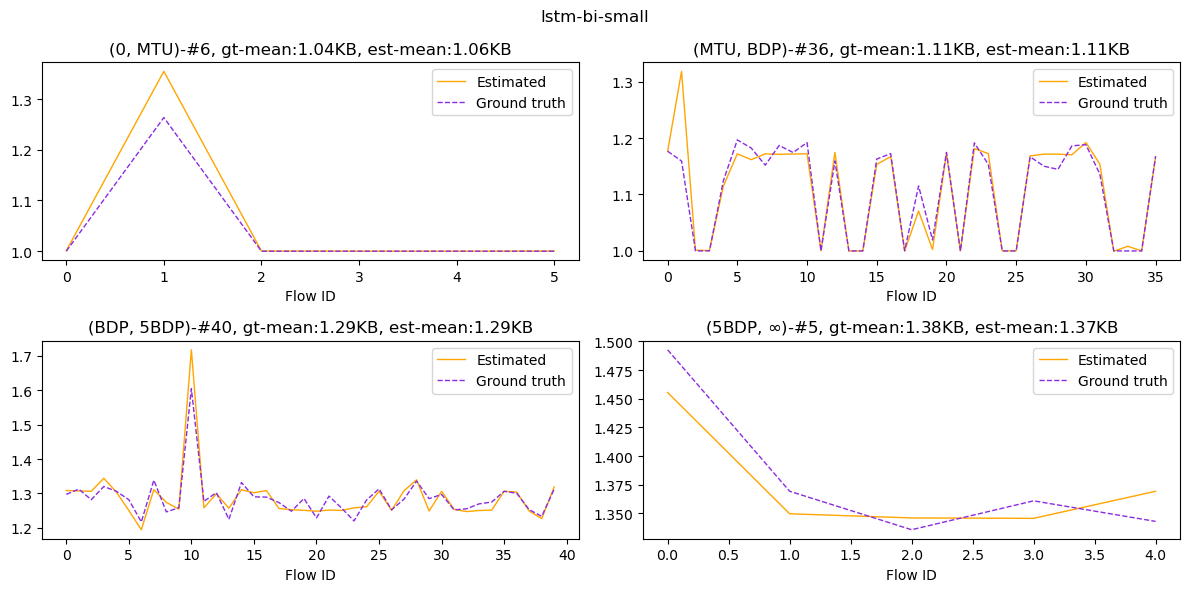

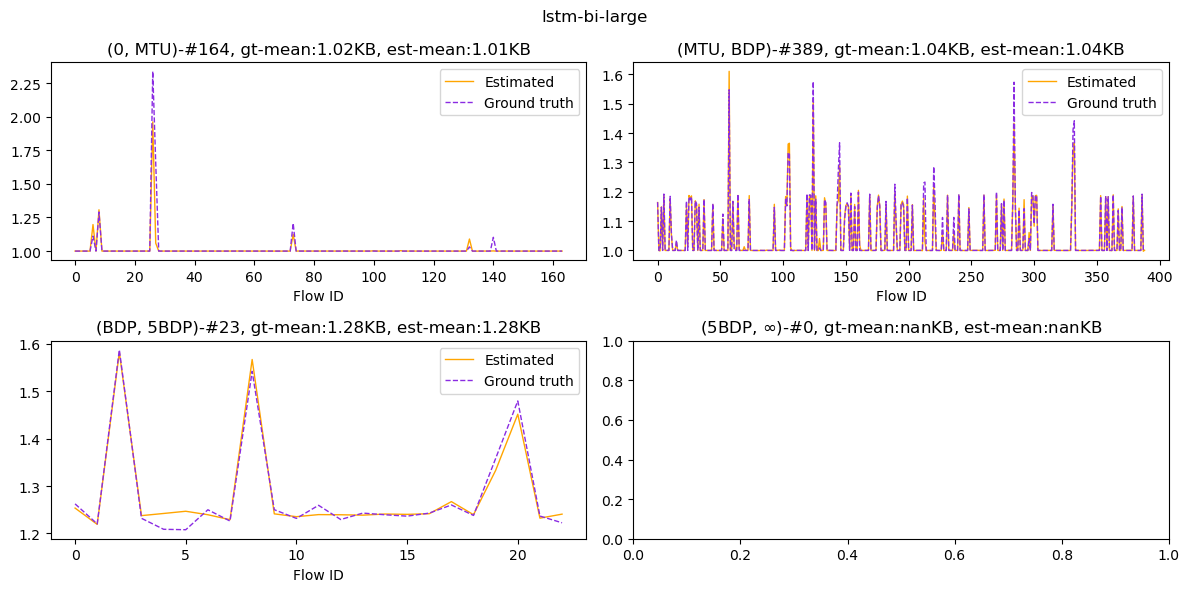

In [21]:
dir_input_synthetic="/data2/lichenni/path_perflow_busy"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_bi_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_large_shard10000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0]
]

file_tag = "-abs"
enable_abs = True
title_str_list = ["lstm-bi-small","lstm-bi-large"]
main_title_list=['train','test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [1]:
    res_total=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0 or version_id_test==1:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                if version_id_test==0:
                    data_list_test=data_list["train"]
                else:
                    data_list_test=data_list["test"]
                    
                dir_input=dir_input_synthetic
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                for shard in np.arange(0, 2000):
                    for n_flows in [1000]:
                        for n_hosts in [3]:
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            for sample in [0]:
                                fid = np.load(f"{dir_input}/{spec}/fid{topo_type_cur}s{sample}.npy")
                                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]):
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}")
                                    )
            
            len_tracks=len(data_list_test)
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_model=[]
            plt.figure(fig_index,figsize=(12, 6))
            plt.suptitle(f"{title_str_list[program_name_idx]}")
            for spec, src_dst_pair_target, topo_type, segment_id in [data_list_test[5]]:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                queue_len_est = data['queue_len_est']
                output = data['output']
                
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                fid=[int(flow_id) for flow_id in busy_periods[segment_id]]
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins_target=np.digitize(sizes,size_bucket_list)

                for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
                    gt = np.extract(bins_target==i, output)
                    estimated = np.extract(bins_target==i, queue_len_est)
                    
                    plt.subplot(2, 2, i + 1)
                    plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}, gt-mean:{np.mean(gt):.2f}KB, est-mean:{np.mean(estimated):.2f}KB")
                    if(len(gt)==0): continue
                    
                    
                    plt.plot(estimated, label="Estimated", linewidth=1,color=color_list[1])
                    
                    plt.plot(gt, label="Ground truth", linewidth=1,color=color_list[3],linestyle='dashed')

                    # plt.axhline(99, color='green', linewidth=0.5)
                    # plt.xscale('log')
                    plt.xlabel('Flow ID')
                    plt.legend()
                    
                    # plt.xlim([0, 16])
                    # plt.ylim([80, 100])
                plt.tight_layout()
            fig_index+=1